In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [4]:
input_image = cv2.imread("saffrun.jpg", cv2.IMREAD_GRAYSCALE)

Text(0.5, 1.0, 'Magnitude Spectrum')

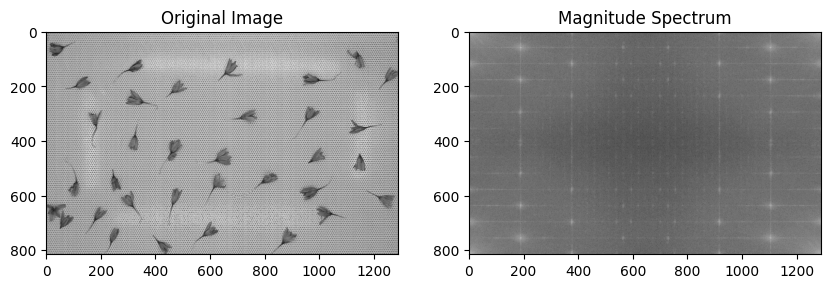

In [6]:
# Perform FFT
f_transform = np.fft.fft2(input_image)
magnitude_spectrum = 20*np.log(np.abs(f_transform))


# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')


# Plot the magnitude spectrum
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')

Text(0.5, 1.0, 'Magnitude Spectrum')

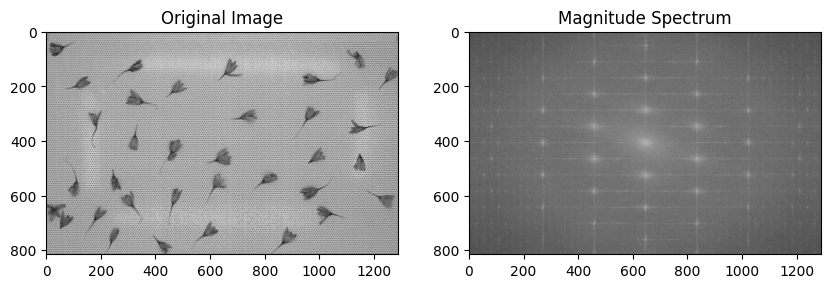

In [16]:
f_transform = np.fft.fft2(input_image)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = 20*np.log(np.abs(f_transform_shifted))

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')


# Plot the magnitude spectrum
plt.subplot(1, 2, 2)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')

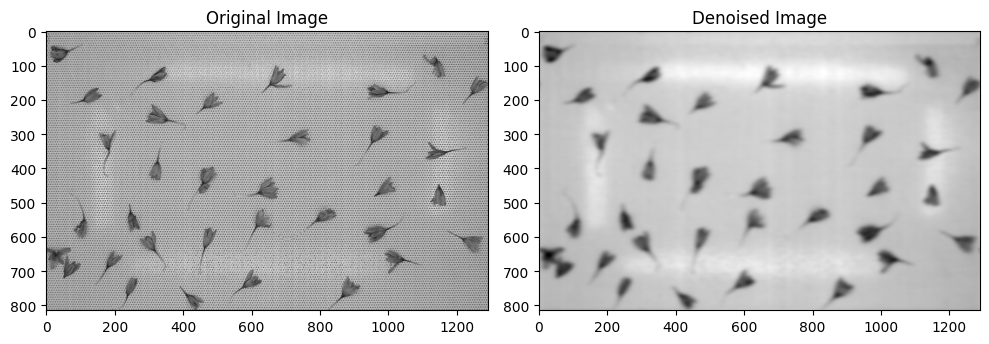

In [15]:
# Define Gaussian filter parameters

# Define Gaussian filter parameters
kernel_x, kernel_y = input_image.shape
sigma = 30

# Construct Gaussian filter in Fourier space
x = np.linspace(-kernel_x // 2, kernel_x // 2, kernel_x)
y = np.linspace(-kernel_y // 2, kernel_y // 2, kernel_y)
x, y = np.meshgrid(x, y)
gaussian_filter = np.exp(-(x**2 + y**2) / (2 * sigma**2))

# Transpose the Gaussian filter to match the shape of f_transform_shifted
gaussian_filter = gaussian_filter.T

# Apply Gaussian filter in the frequency domain
f_transform_shifted_filtered = f_transform_shifted * gaussian_filter

# Shift back to original position
filtered_f_transform_shifted = np.fft.ifftshift(f_transform_shifted_filtered)

# Inverse FFT to get the denoised image
denoised_image = np.fft.ifft2(filtered_f_transform_shifted)
denoised_image = np.abs(denoised_image)

# Normalizing the output
denoised_image = denoised_image / np.max(denoised_image)

# Plot the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')

# Plot the denoised image
plt.subplot(1, 2, 2)
plt.imshow(denoised_image, cmap='gray')
plt.title('Denoised Image')

# Show plots
plt.tight_layout()
plt.show()

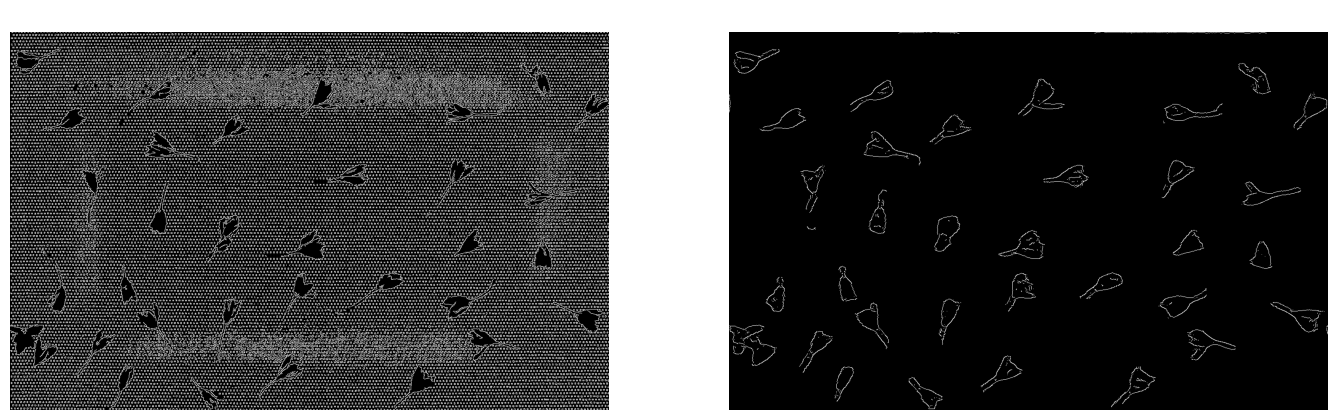

In [22]:
edges1 = cv2.Canny(np.uint8(input_image), 100, 300) # Canny Edge Detection
# Canny Edge Detection
# we should cast filtered image data to uint8 because that's what canny function expects,
# also it should be multiplied by 255 to be in range 0 to 255
# apertureSize parameter indicates the size of sobel kernel used for calculating gradient.
# the more the apertureSize, the smoother the image. this worked for me with apertureSize=5
# and didn't work with default value which is 3
edges = cv2.Canny(np.uint8(denoised_image * 255), 100, 300, apertureSize=5) 
# Display Canny Edge Detection Image
fig, axs = plt.subplots(1, 2, figsize=(17, 17))

# Plot before canceling noise by Fourier transform
axs[0].imshow(edges1, cmap='gray')
axs[0].set_title('Canny Edge Detection before canceling noise by Fourier transform', color='white')
axs[0].axis('off')

# Plot after canceling noise by Fourier transform
axs[1].imshow(edges, cmap='gray')
axs[1].set_title('Canny Edge Detection after canceling noise by Fourier transform', color='white')
axs[1].axis('off')

plt.show()

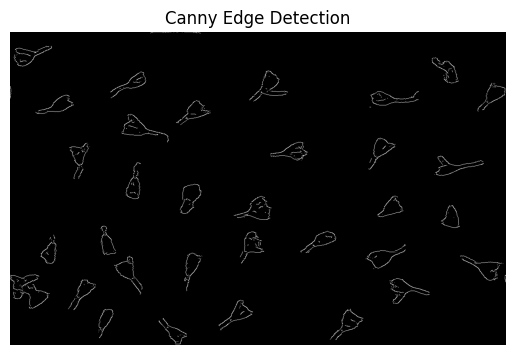

In [47]:
edges = cv2.Canny(np.uint8(denoised_image * 255), 100, 350, apertureSize=5) 
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()

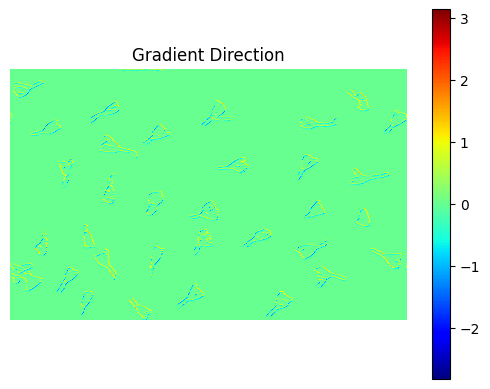

In [51]:
# Compute gradient in x and y directions using Sobel operator
gradient_x = cv2.Sobel(edges, cv2.CV_64F, 1, 0, ksize=3)
gradient_y = cv2.Sobel(edges, cv2.CV_64F, 0, 1, ksize=3)

# Calculate gradient direction using arctan2
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Plot the gradient direction
plt.imshow(gradient_direction, cmap='jet')
plt.title('Gradient Direction')
plt.colorbar()
plt.axis('off')
plt.show()

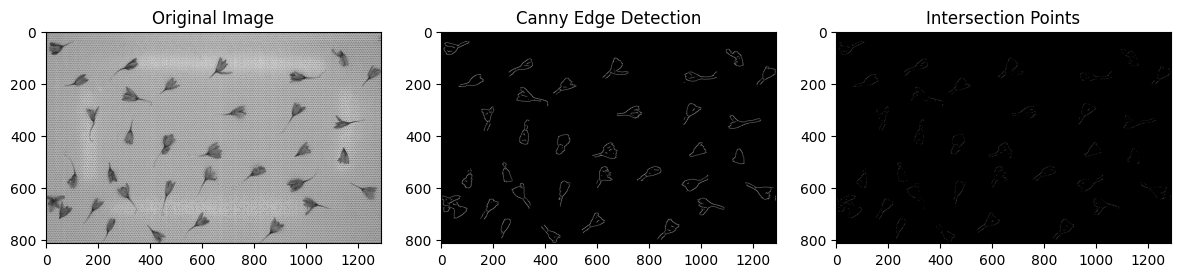

In [53]:
# Threshold the gradient direction to isolate regions with stem and petal directions
stem_direction_threshold = np.pi / 2  # Assuming the stem direction is approximately vertical
petal_direction_threshold = np.pi / 4  # Assuming the petal direction is at an angle relative to the stem

stem_region = np.abs(gradient_direction - stem_direction_threshold) < np.pi / 6
petal_region = np.abs(gradient_direction - petal_direction_threshold) < np.pi / 6

# Find the intersection points between Canny edges and gradient direction lines in stem and petal regions
stem_intersection_points = cv2.bitwise_and(edges, stem_region.astype(np.uint8)) > 0
petal_intersection_points = cv2.bitwise_and(edges, petal_region.astype(np.uint8)) > 0

# Convert boolean arrays to integer arrays
stem_intersection_points = stem_intersection_points.astype(np.uint8) * 255
petal_intersection_points = petal_intersection_points.astype(np.uint8) * 255

# Combine stem and petal intersection points
intersection_points = cv2.bitwise_or(stem_intersection_points, petal_intersection_points)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')

plt.subplot(1, 3, 3)
plt.imshow(intersection_points, cmap='gray')
plt.title('Intersection Points')

plt.tight_layout()
plt.show()